# Mortgage Risk Analyzer v2

## Intro
This is a non-dimentional alaysis of mortgage expenditure minimization.  

- Goal: minimize expenses  
    - expenses = payments + interest  
- Nondimentional Implementation: x = expenses / housePrice  
    - if x = 1.5, that means that you actually pay 1.5 times the house price.

## Code
skip this if you're not interested

In [1]:
import ipywidgets as widgets
input_sliders = []
input_sliders.append(widgets.FloatSlider(value=3,min=1,max=10,step=0.01,description='Intrest Rate (%/yr)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
input_sliders.append(widgets.IntSlider(value=300,min=100,max=1000,description='House Price ($k)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
input_sliders.append(widgets.IntSlider(value=60,min=1,max=100,description='Down Payment ($k)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
input_sliders.append(widgets.IntSlider(value=30,min=1,max=60,description='Term (years)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
input_sliders.append(widgets.FloatSlider(value=2,min=0,max=5,description='Private Mortgage Insurance (%/yr)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
input_sliders.append(widgets.FloatSlider(value=1,min=1,max=5,description='Payment Multiplier (%)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
input_sliders.append(widgets.IntSlider(value=1500,min=500,max=5000,description='Specific Payment Amount ($)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))

input_radios = widgets.RadioButtons(
    options=['Minimum', 'Using Payment Multiplier', 'Using Specific Amount'],
    value='Minimum',
    layout={'width': 'max-content'},
    description='Payment:'
)

onetime_sliders = []
onetime_sliders.append(widgets.FloatSlider(value=2,min=1,max=5,description='Closing Costs (%)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
onetime_sliders.append(widgets.IntSlider(value=350,min=300,max=400,description='Appraisal Fee ($)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
onetime_sliders.append(widgets.IntSlider(value=400,min=300,max=500,description='Inspection Fee ($)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))

lifetime_sliders = []
lifetime_sliders.append(widgets.IntSlider(value=600,min=500,max=5000,description='Home Insurance ($/yr)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
lifetime_sliders.append(widgets.IntSlider(value=200,min=0,max=700,description='HOA contribution ($/mo)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
lifetime_sliders.append(widgets.FloatSlider(value=4.5,min=0,max=200,description='Property Taxes ($k/yr)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))
lifetime_sliders.append(widgets.IntSlider(value=300,min=0,max=1000,description='Utilities ($/mo)',style={'description_width': 'initial'},layout=widgets.Layout(width='100%')))


This function calculates x. It goes through each month and calculates the monthly payment amount, & intrest.

In [2]:
def calculateX(intrestRate, housePrice, downPayment, term, privateMortgageInsurancePct=0, minPaymentMuliplyer=1, specificPaymentAmount=None):
    intrestRate = intrestRate/100
    housePrice = housePrice*1000
    downPayment = downPayment*1000
    privateMortgageInsurancePct = privateMortgageInsurancePct/100/12 # monthly pmi
    
    #print('Calculating x for ',intrestRate,' ',housePrice,' ',downPayment,' ',term,' ',minPaymentMuliplyer)
    n = 12*term
    monthlyInterestRate = intrestRate / 12
    #print("monthlyInterestRate =",monthlyInterestRate)
    r = 1/(1+monthlyInterestRate)
    loan = housePrice - downPayment
    #print("loan =",loan)
    minPayment = loan * ((1-r)/(r-r**(n+1)))
    #print("minpayment =",minPayment)
    payment = minPayment * minPaymentMuliplyer
    if specificPaymentAmount:
        payment = specificPaymentAmount
    #print("payment =",payment)
    
    paymentSum = 0
    totalmonths = 0
    totalmonthsWithPMI = 0
    totalprivateMortgageInsurance = 0
    balance = loan
    
    while balance > 1:
        #print('balance ',balance)
        # 1 month passes
        interest = balance * monthlyInterestRate
        #print('interest ',interest)
        
        p = payment
        #print('payment ',p)
        if interest + balance < payment:
            p = interest + balance
        
        privateMortgageInsurance = 0
        if ((paymentSum + downPayment) < loan * 0.2) and (totalmonths < term*12/2):
            privateMortgageInsurance = privateMortgageInsurancePct*loan
            totalmonthsWithPMI += 1
            totalprivateMortgageInsurance += privateMortgageInsurance
        
        if p < interest:
            #print('error. payment too small ',intrestRate,' ',housePrice,' ',downPayment,' ',term,' ',minPaymentMuliplyer)
            return 0,0,0,0,0,0
            
        balance = balance - (p) + (interest)
        paymentSum += p
        totalmonths += 1
    expenses = paymentSum + downPayment + totalprivateMortgageInsurance
    x = expenses / housePrice
    return x, totalmonths, minPayment, payment, totalmonthsWithPMI, totalprivateMortgageInsurance
    
        

In [3]:
def calculateOneTimeExpenses(housePrice, downPayment, closingCostsPrct=0, appraisalFee=0, inspectionFee=0):
    housePrice = housePrice*1000
    downPayment = downPayment*1000
    closingCostsPrct = closingCostsPrct/100
    loan = housePrice - downPayment
    closingCosts = closingCostsPrct*loan
    return closingCosts + appraisalFee + inspectionFee

In [4]:
def calculateLifetimeExpensesPerMonth(homeInsurance,HOA,propertyTaxes,utilities):
    return homeInsurance/12 + HOA + propertyTaxes*1000/12 + utilities


In [5]:
import matplotlib.pyplot as plt
def mccgraph(x,y,xlabel):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel('x')
    plt.plot(x, y, '-ok')
    plt.show()

In [6]:
def input_slider_values():
    values = []
    for s in input_sliders:
        values.append(s.value)
    if input_radios.value == 'Minimum':
        values[5] = 1
        values[6] = None
    if input_radios.value == 'Using Payment Multiplier':
        values[6] = None
    if input_radios.value =='Using Specific Amount':
        values[5] = 1
        
    return values
def onetime_slider_values():
    values = []
    for s in onetime_sliders:
        values.append(s.value) 
    return values
def lifetime_slider_values():
    values = []
    for s in lifetime_sliders:
        values.append(s.value)
    return values


In [7]:
def show_comparitive_graphs():
    variables = []
    for s in input_sliders:
        smin = int(s.min*100)
        smax = int(s.max*100)
        diff = smax-smin
        points_per_graph = 20
        step = int(diff/points_per_graph)
        variables.append([x / 100 for x in range(smin, smax, step)])
    for i,var in enumerate(variables):
        #print(var)
        values = input_slider_values()
        output = []
        xlabel = ''
        xvalues = []
        for v in var:
            #print(v)
            values[i] = v
            if input_radios.value == 'Minimum':
                values[5] = 1
                values[6] = None
            if input_radios.value == 'Using Payment Multiplier':
                values[6] = None
            if input_radios.value =='Using Specific Amount':
                values[5] = 1
            xlabel = input_sliders[i].description
            x, totalmonths, minPayment, payment, totalmonthsWithPMI, totalPMI = calculateX(values[0],values[1],values[2],values[3],values[4],values[5],values[6])
            if x>0:
                output.append(x)
                xvalues.append(v)
        mccgraph(xvalues, output, xlabel)

In [8]:
from IPython.display import clear_output
reload_graphs_button = widgets.Button(description="Reload Graphs")
reload_single_option_button = widgets.Button(description="Reload Single Option")
def reload_graphs(change):
    plt.close('all')
    clear_output(wait=True)
    display(reload_graphs_button)
    show_comparitive_graphs()
def reload_single_option_data(change):
    plt.close('all')
    clear_output(wait=True)
    display(reload_single_option_button)
    values = input_slider_values()
    x, totalmonths, minPayment, payment, totalmonthsWithPMI, totalPMI = calculateX(values[0],values[1],values[2],values[3],values[4],values[5],values[6])
    print("Minimum monthly payment = $"+str(round(minPayment,2))+" and actual monthly payment = $"+str(round(payment,2)))
    print("You will spend $"+str(int(x*values[1]))+"k on your house worth $"+str(int(values[1]))+"k in "+str(round(totalmonths/12,2))+" years (x="+str(round(x,2))+")")
    print("Months paid with PMI = "+str(round(totalmonthsWithPMI,2))+" months and total PMI amount = $"+str(round(totalPMI,2)))
    onetimevalues = onetime_slider_values()
    oneTimeExpenses = calculateOneTimeExpenses(values[1],values[2],onetimevalues[0],onetimevalues[1],onetimevalues[2])
    print("One time expenses = $"+str(round(oneTimeExpenses,2)))
    lifetimevalues = lifetime_slider_values()
    lifetimeExpensesPerMonth = calculateLifetimeExpensesPerMonth(lifetimevalues[0],lifetimevalues[1],lifetimevalues[2],lifetimevalues[3])
    print("Lifetime expenses = $"+str(round(lifetimeExpensesPerMonth,2))+"/month")

## Fixed Rate Mortgage
Set the input values for the various variables here. Then to calculate the fixed rate analysis, press the buttons below.

In [9]:
print("Loan Variables")
for s in input_sliders:
    display(s)
display(input_radios)
print("One Time Expenses")
for s in onetime_sliders:
    display(s)
print("Lifetime Expenses")
for s in lifetime_sliders:
    display(s)

Loan Variables


FloatSlider(value=3.0, description='Intrest Rate (%/yr)', layout=Layout(width='100%'), max=10.0, min=1.0, step…

IntSlider(value=300, description='House Price ($k)', layout=Layout(width='100%'), max=1000, min=100, style=Sli…

IntSlider(value=60, description='Down Payment ($k)', layout=Layout(width='100%'), min=1, style=SliderStyle(des…

IntSlider(value=30, description='Term (years)', layout=Layout(width='100%'), max=60, min=1, style=SliderStyle(…

FloatSlider(value=2.0, description='Private Mortgage Insurance (%/yr)', layout=Layout(width='100%'), max=5.0, …

FloatSlider(value=1.0, description='Payment Multiplier (%)', layout=Layout(width='100%'), max=5.0, min=1.0, st…

IntSlider(value=1500, description='Specific Payment Amount ($)', layout=Layout(width='100%'), max=5000, min=50…

RadioButtons(description='Payment:', layout=Layout(width='max-content'), options=('Minimum', 'Using Payment Mu…

One Time Expenses


FloatSlider(value=2.0, description='Closing Costs (%)', layout=Layout(width='100%'), max=5.0, min=1.0, style=S…

IntSlider(value=350, description='Appraisal Fee ($)', layout=Layout(width='100%'), max=400, min=300, style=Sli…

IntSlider(value=400, description='Inspection Fee ($)', layout=Layout(width='100%'), max=500, min=300, style=Sl…

Lifetime Expenses


IntSlider(value=600, description='Home Insurance ($/yr)', layout=Layout(width='100%'), max=5000, min=500, styl…

IntSlider(value=200, description='HOA contribution ($/mo)', layout=Layout(width='100%'), max=700, style=Slider…

FloatSlider(value=4.5, description='Property Taxes ($k/yr)', layout=Layout(width='100%'), max=200.0, style=Sli…

IntSlider(value=300, description='Utilities ($/mo)', layout=Layout(width='100%'), max=1000, style=SliderStyle(…

In [10]:
reload_single_option_data(None)
reload_single_option_button.on_click(reload_single_option_data)

Button(description='Reload Single Option', style=ButtonStyle())

Minimum monthly payment = $1011.85 and actual monthly payment = $1011.85
You will spend $424k on your house worth $300k in 30.0 years (x=1.41)
Months paid with PMI = 0 months and total PMI amount = $0
One time expenses = $5550.0
Lifetime expenses = $925.0/month


## Variable analysis
This shows graphs of how each variable impacts x. Change the sliders and then reload the graphs to see how the graphs change. These are ussed to asses the impact of differences in variables. For example, the difference in x between a payment multiplier of 1 and 2 is much larger than the difference in x between a payment multiplier of 2 and 3.

Button(description='Reload Graphs', style=ButtonStyle())

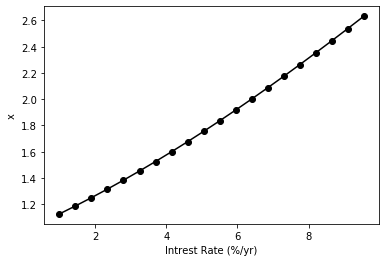

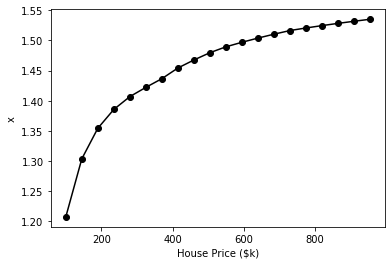

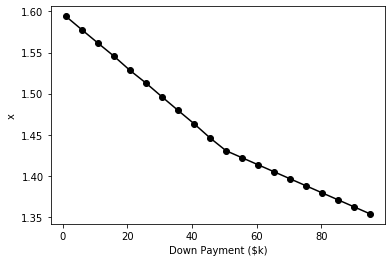

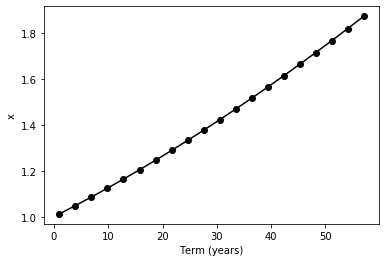

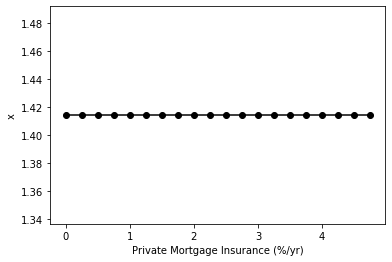

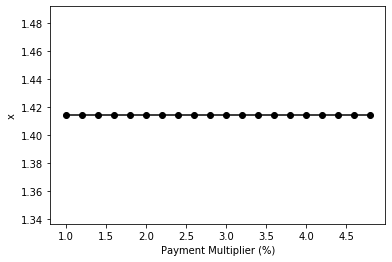

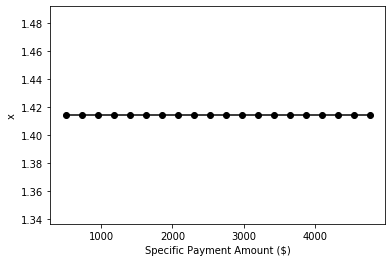

In [11]:
reload_graphs(None)
reload_graphs_button.on_click(reload_graphs)

## 2 Options Analysis
This is an analysis that compairs two house options

In [12]:
housePrice = 200
downPayment = 60
intrestRate = 3
term = 30
privateMortgageInsurancePct = 0
minPaymentMuliplyer = 2
specificPaymentAmount = None

In [13]:

downPayment = 50
x, totalmonths, minPayment, payment, totalmonthsWithPMI, totalPMI = calculateX(intrestRate, housePrice, downPayment, term, privateMortgageInsurancePct,minPaymentMuliplyer,specificPaymentAmount)
option1 = x
print("Option 1")
print("Minimum monthly payment = $"+str(round(minPayment,2))+" and actual monthly payment = $"+str(round(payment,2)))
print("You will spend $"+str(int(x*housePrice))+"k on your house in "+str(round(totalmonths/12,2))+" years (x="+str(round(x,2))+")")
print("Months paid with PMI = "+str(round(totalmonthsWithPMI,2))+" months and total PMI amount = $"+str(round(totalPMI,2)))
    
downPayment = 40
x, totalmonths, minPayment, payment, totalmonthsWithPMI, totalPMI = calculateX(intrestRate, housePrice, downPayment, term, privateMortgageInsurancePct,minPaymentMuliplyer,specificPaymentAmount)
option2 = x
print("Option 2")
print("Minimum monthly payment = $"+str(round(minPayment,2))+" and actual monthly payment = $"+str(round(payment,2)))
print("You will spend $"+str(int(x*housePrice))+"k on your house in "+str(round(totalmonths/12,2))+" years (x="+str(round(x,2))+")")
print("Months paid with PMI = "+str(round(totalmonthsWithPMI,2))+" months and total PMI amount = $"+str(round(totalPMI,2)))

xdiff = option1-option2
print('Option 1 is '+str(round(xdiff,2))+' more than Option 2')
expensesdiff = option1*housePrice - option2*housePrice
print('Option 1 is $'+str(round(expensesdiff,2))+'k more than Option 2')

Option 1
Minimum monthly payment = $632.41 and actual monthly payment = $1264.81
You will spend $228k on your house in 11.75 years (x=1.14)
Months paid with PMI = 0 months and total PMI amount = $0
Option 2
Minimum monthly payment = $674.57 and actual monthly payment = $1349.13
You will spend $230k on your house in 11.75 years (x=1.15)
Months paid with PMI = 0 months and total PMI amount = $0
Option 1 is -0.01 more than Option 2
Option 1 is $-1.88k more than Option 2
